In [0]:
!nvidia-smi

Sat May 30 03:58:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My\ Drive/Projects/Anomaly_Detection_Time_Series

/content/drive/My Drive/Projects/Anomaly_Detection_Time_Series


In [0]:
import os
import json
import pickle
import matplotlib
import numpy as np
import pandas as po
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [0]:
import tensorflow as tf
from nbeats_model import NBeatsNet
import tensorflow.keras.backend as K

Using TensorFlow backend.


In [0]:
os.makedirs('Anomaly_Detection', exist_ok=True)

In [0]:
class weekday_args:
  def __init__(self):
    self.val_start = 12*24*150
    self.test_start = 12*24*200
    self.train_seq_len = 12*24*10
    self.val_seq_len = 12*24
    
    self.seasonality = 12*24
    self.batch_size = 512
    self.num_epochs = 100
    self.hidden_dim = 100
    self.theta_1 = 288*7
    self.theta_2 = 288*7
    self.nb_blocks_per_stack = 5
    
    self.upper_quantile = 0.9950
    self.lower_quantile = 0.0050

    self.save_folder = 'weekday_anomalies_upper_{}_lower_{}'.format(int(100*self.upper_quantile), int(100*self.lower_quantile))

In [0]:
args = weekday_args()

In [0]:
args.save_folder

'weekday_anomalies_upper_99_lower_0'

In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

In [0]:
weekday_power_series = []
weekend_power_series = []
for i in tqdm(range(0, len(df)-7, 7*288)):
  weekday_power_series += df['W'][i:i+5*288].tolist()
  weekend_power_series += df['W'][i+5*288:i+7*288].tolist()
weekday_power_series = np.array(weekday_power_series)
weekend_power_series = np.array(weekend_power_series)

100%|██████████| 50/50 [00:00<00:00, 2928.25it/s]


In [0]:
os.makedirs('Anomaly_Detection/' + args.save_folder, exist_ok=True)

In [0]:
train_arr = weekday_power_series[: args.val_start]
val_arr = weekday_power_series[args.val_start: args.test_start]
test_arr = weekday_power_series[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data[i - train_seq_len: i].T.tolist())
        y.append(data[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [0]:
X_train, y_train = make_windows(train_arr)
X_val, y_val = make_windows(val_arr)
X_test, y_test = make_windows(test_arr)

100%|██████████| 11233/11233 [00:01<00:00, 8330.85it/s]


In [0]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [0]:
sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-8, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4)
loss_funk = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

In [0]:
def pinball_loss(y_true, y_pred, tau):
    err = y_true - y_pred
    return K.mean(K.maximum(tau*err, (tau-1)*err), axis = -1)

In [0]:
loss_u = lambda y_true, y_pred : pinball_loss(y_true, y_pred, args.upper_quantile)
loss_l = lambda y_true, y_pred : pinball_loss(y_true, y_pred, args.lower_quantile)

In [0]:
model_u = NBeatsNet(backcast_length = args.train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
model_u.compile_model(loss=loss_u, learning_rate = 1e-3)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 2880, 1)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2880)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 100)          288100      lambda_1[0][0]                   
                                                                 subtract_1[0][0]                 
                                                                 subtract_2[0][0]                 
                                                                 subtract_3[0][0]           

In [0]:
history_u = model_u.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Train on 40033 samples, validate on 11233 samples
Epoch 1/100
40033/40033 [==============================] - 10s 244us/step - loss: 0.0114 - val_loss: 0.0024
Epoch 2/100
40033/40033 [==============================] - 8s 193us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 3/100
40033/40033 [==============================] - 8s 191us/step - loss: 0.0013 - val_loss: 0.0022
Epoch 4/100
40033/40033 [==============================] - 8s 191us/step - loss: 0.0012 - val_loss: 0.0022
Epoch 5/100
40033/40033 [==============================] - 8s 190us/step - loss: 0.0011 - val_loss: 0.0023
Epoch 6/100
40033/40033 [==============================] - 8s 191us/step - loss: 0.0010 - val_loss: 0.0017
Epoch 7/100
40033/40033 [==============================] - 8s 190us/step - loss: 0.0010 - val_loss: 0.0023
Epoch 8/100
40033/40033 [==============================] - 8s 191us/step - loss: 0.0011 - val_loss: 0.0022
Epoch 9/100
40033/40033 [==============================] - 8s 191us/step - loss: 9.4904e-04 -

In [0]:
best_epoch = np.argmin(np.array(history_u.history['val_loss']))+1
model_u.save_weights('Anomaly_Detection/' + args.save_folder + '/model_upper_{:02d}.h5'.format(best_epoch))
model_u.load_weights('Anomaly_Detection/' + args.save_folder + '/model_upper_{:02d}.h5'.format(best_epoch))
best_epoch

6

In [0]:
y_pred_u = model_u.predict(X_test)

In [0]:
model_l = NBeatsNet(backcast_length = args.train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
model_l.compile_model(loss=loss_l, learning_rate = 1e-3)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 2880, 1)      0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2880)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 100)          288100      lambda_2[0][0]                   
                                                                 subtract_11[0][0]                
                                                                 subtract_12[0][0]                
                                                                 subtract_13[0][0]          

In [0]:
history_l = model_l.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Train on 40033 samples, validate on 11233 samples
Epoch 1/100
40033/40033 [==============================] - 8s 207us/step - loss: 0.0028 - val_loss: 0.0010
Epoch 2/100
40033/40033 [==============================] - 8s 191us/step - loss: 0.0012 - val_loss: 8.9684e-04
Epoch 3/100
40033/40033 [==============================] - 8s 192us/step - loss: 0.0010 - val_loss: 9.1520e-04
Epoch 4/100
40033/40033 [==============================] - 8s 192us/step - loss: 9.8998e-04 - val_loss: 8.5009e-04
Epoch 5/100
40033/40033 [==============================] - 8s 192us/step - loss: 9.9628e-04 - val_loss: 8.6990e-04
Epoch 6/100
40033/40033 [==============================] - 8s 192us/step - loss: 9.3285e-04 - val_loss: 8.5574e-04


In [0]:
best_epoch = np.argmin(np.array(history_l.history['val_loss']))+1
model_l.save_weights('Anomaly_Detection/' + args.save_folder + '/model_lower_{:02d}.h5'.format(best_epoch))
model_l.load_weights('Anomaly_Detection/' + args.save_folder + '/model_lower_{:02d}.h5'.format(best_epoch))
best_epoch

4

In [0]:
y_pred_l = model_l.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff093002978> has a label of '_Quantile' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff092fc63c8> has a label of '_Quantile' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.


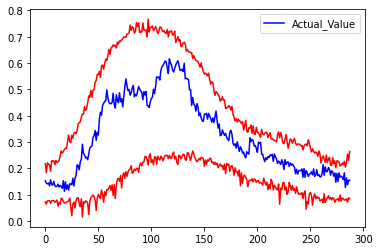

In [0]:
plt.plot(y_test[0], color = 'blue')
plt.plot(y_pred_u[0], color = 'red')
plt.plot(y_pred_l[0], color = 'red')
plt.legend(['Actual_Value', '_Quantile'.format(args.upper_quantile), '_Quantile'.format(args.lower_quantile)])

In [0]:
forecasts_l = []
forecasts_u = []
actuals = []
for i in tqdm(range(y_pred_u.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts_u += y_pred_u[12*24*i].reshape(-1).tolist()
  forecasts_l += y_pred_l[12*24*i].reshape(-1).tolist()
  actuals += y_test[12*24*i].reshape(-1).tolist()

100%|██████████| 39/39 [00:00<00:00, 13630.35it/s]


In [0]:
u = np.array([f_u - a for f_u, a in zip(forecasts_u, actuals)])
u_t = np.where(u < 0, actuals, None)
u_picp = np.where(u < 0, 0, 1)
u_dev = np.where(u > 0, u, None)

In [0]:
l = np.array([a - f_l for a, f_l in zip(actuals, forecasts_l)])
l_t = np.where(l < 0, actuals, None)
l_picp = np.where(l < 0, 0, 1)
l_dev = np.where(l > 0, l, None)

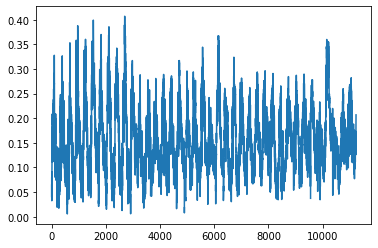

In [0]:
plt.plot(u_dev)

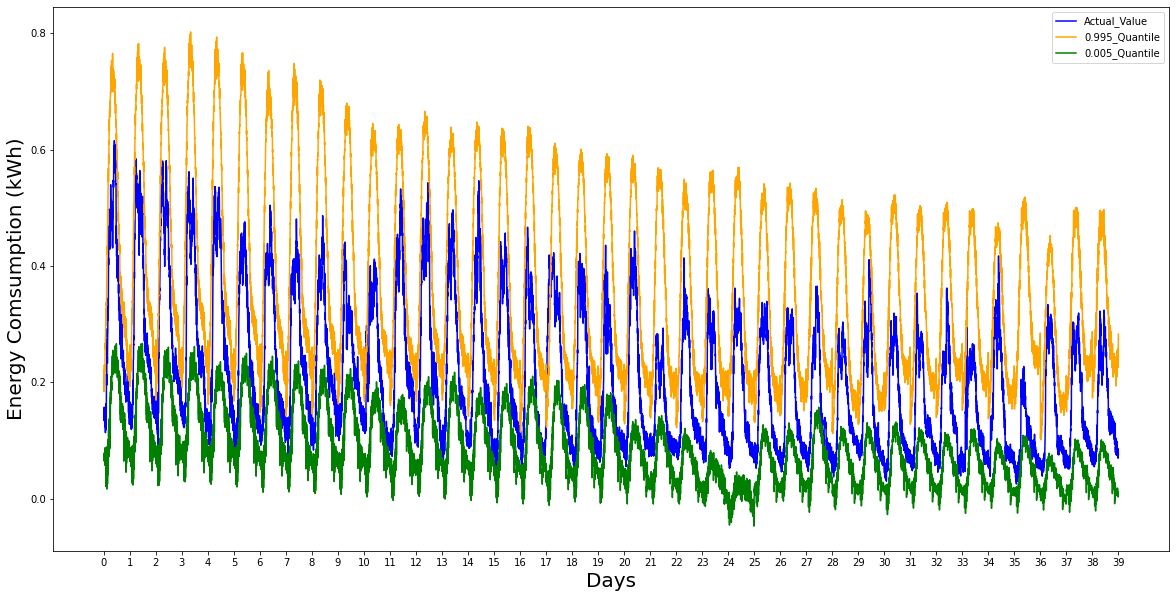

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'blue')
plt.plot(forecasts_u, color = 'orange')
plt.plot(forecasts_l, color = 'green')
plt.legend(['Actual_Value', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/quantiles_weekday_{}_{}.png'.format(args.upper_quantile, args.lower_quantile))

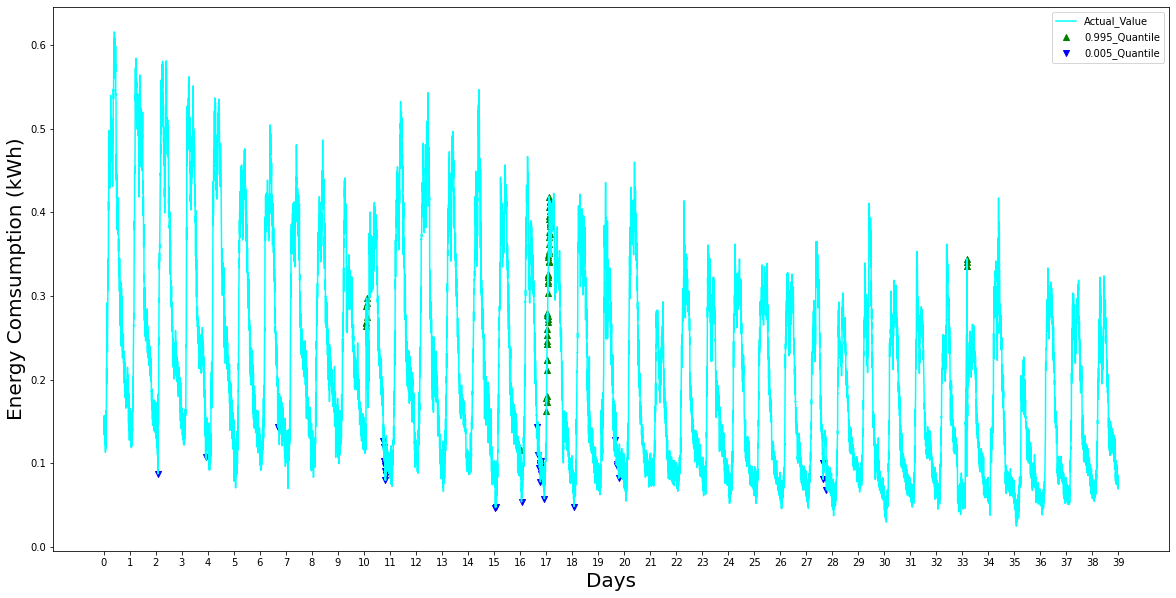

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'cyan')
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['Actual_Value', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_actuals_weekday_{}_{}.png'.format(args.upper_quantile, args.lower_quantile))

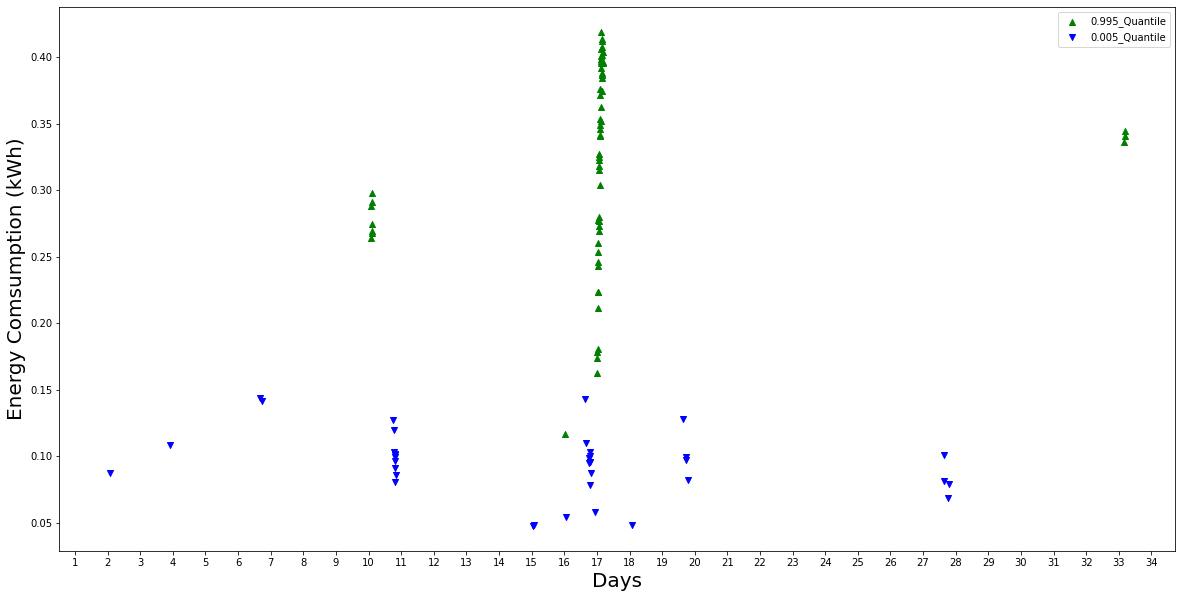

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_weekday_{}_{}.png'.format(args.upper_quantile, args.lower_quantile))

In [0]:
if not os.path.exists('Anomaly_Detection/PI_eval_metrics.csv'):
  results = po.DataFrame(columns = ['model', 'upper_quantile', 'lower_quantile', 'PICP', 'PINAW'])  
else: 
  results = po.read_csv('Anomaly_Detection/PI_eval_metrics.csv')

In [0]:
PICP = (np.sum(l_picp) + np.sum(u_picp))/(len(l_picp) + len(u_picp))
PICP

0.9956374643874644

In [0]:
E = np.array(actuals).max() - np.array(actuals).min()
N = len(actuals)

In [0]:
u_l = np.array([f_u - f_l for f_u, f_l in zip(forecasts_u, forecasts_l)])

In [0]:
PINAW = np.sum(u_l)/(N*E)
PINAW

0.4655414422363468

In [0]:
mu = 2
eta = 2

In [0]:
gamma = 0 if PICP >= mu else 1

In [0]:
CWC = PINAW*(1 + gamma*np.exp(eta*(mu - PICP)))
CWC

3.935598067543451

In [0]:
errors = {'model': 'NBEATS_weekday',
          'upper_quantile': args.upper_quantile,
          'lower_quantile': args.lower_quantile,
          'PICP': PICP,
          'PINAW': PINAW,
          'CWC': CWC      
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [0]:
results

,model,upper_quantile,lower_quantile,PICP,PINAW,CWC
0,NBEATS_weekday,0.960,0.030,0.996928,0.565448,4.769320
1,NBEATS_weekend,0.960,0.030,0.985185,0.415431,0.415431
2,NBEATS_weekday,0.980,0.030,0.969373,0.331278,2.933738
3,NBEATS_weekend,0.980,0.030,0.963889,0.422425,0.845790
4,NBEATS_weekday,0.960,0.010,0.991186,0.418753,3.567975
5,NBEATS_weekend,0.960,0.010,0.993981,0.413482,0.413482
6,NBEATS_weekday,0.970,0.040,0.933271,0.283406,2.676486
7,NBEATS_weekday,0.970,0.040,0.915198,0.277274,2.704754
8,NBEATS_weekend,0.970,0.040,0.962500,0.366350,0.734535
9,NBEATS_weekday,0.980,0.020,0.980992,0.348774,3.025742


In [0]:
results.to_csv('Anomaly_Detection/PI_eval_metrics.csv', index=False)

In [0]:
z_scores = stats.zscore(np.array(actuals))

In [0]:
z_u = np.where(z_scores > 3, actuals, None)
z_l = np.where(z_scores < -3, actuals, None)

In [0]:
z_u_picp = np.where(z_scores > 3, 0, 1)
z_l_picp = np.where(z_scores < -3, 0, 1)

In [0]:
z_PICP = (np.sum(z_u_picp) + np.sum(z_l_picp))/(len(z_u_picp) + len(z_l_picp))
z_PICP

0.9989761396011396

In [0]:
'''
errors = {'model': 'z_score',
          'upper_quantile': args.upper_quantile,
          'lower_quantile': args.lower_quantile,
          'PICP': PICP,     
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)
results
results.to_csv('Anomaly_Detection/picp_pinaw.csv', index=False)
'''

"\nerrors = {'model': 'z_score',\n          'upper_quantile': args.upper_quantile,\n          'lower_quantile': args.lower_quantile,\n          'PICP': PICP,     \n          }\nerrors = po.Series(errors)\nresults = results.append(errors, ignore_index=True)\nresults\nresults.to_csv('Anomaly_Detection/picp_pinaw.csv', index=False)\n"

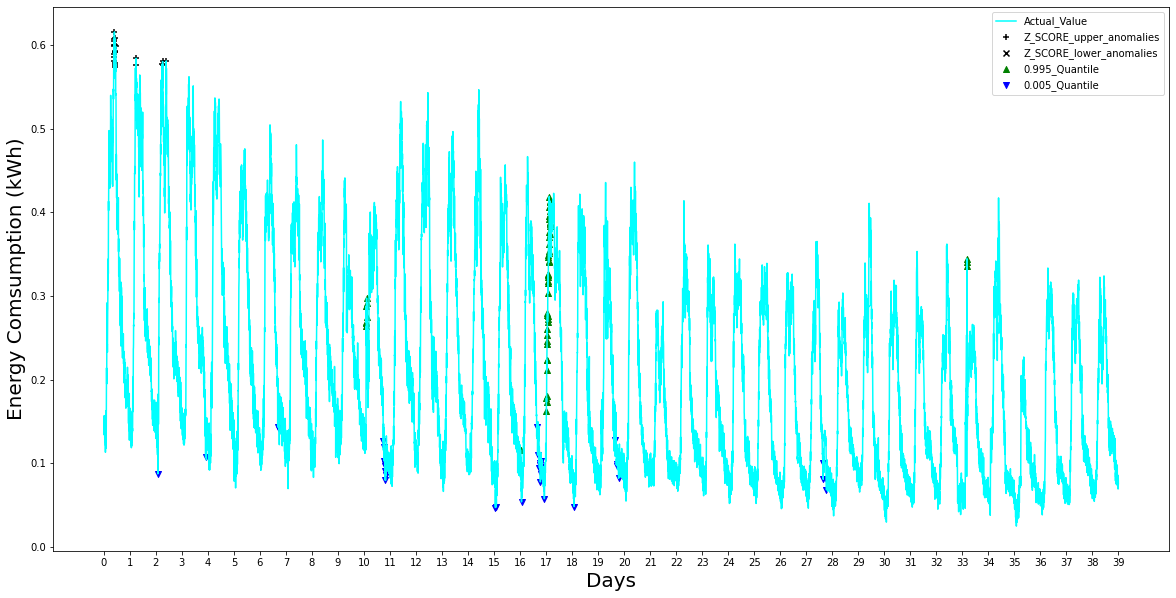

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'cyan')
plt.scatter(range(len(z_u)), z_u, color = 'black', marker = '+')
plt.scatter(range(len(z_l)), z_l, color = 'black', marker = 'x')
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['Actual_Value', 'Z_SCORE_upper_anomalies', 'Z_SCORE_lower_anomalies', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_actuals_weekday_interval_vs_zscore.png')

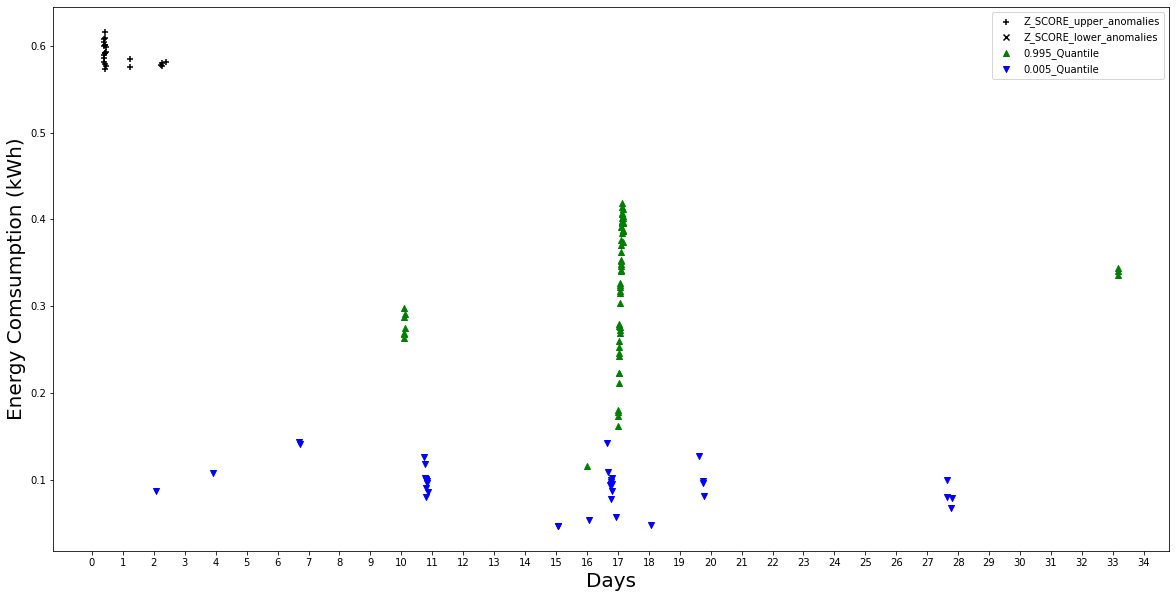

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.scatter(range(len(z_u)), z_u, color = 'black', marker = '+')
plt.scatter(range(len(z_l)), z_l, color = 'black', marker = 'x')
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['Z_SCORE_upper_anomalies', 'Z_SCORE_lower_anomalies', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_weekday_interval_vs_zscore.png')

In [0]:
with open('Anomaly_Detection/' + args.save_folder + '/forecasts_u.pkl', 'wb') as f:
  pickle.dump(forecasts_u, f)

In [0]:
with open('Anomaly_Detection/' + args.save_folder + '/forecasts_l.pkl', 'wb') as f:
  pickle.dump(forecasts_l, f)

In [0]:
with open('Anomaly_Detection/' + args.save_folder + '/actuals.pkl', 'wb') as f:
  pickle.dump(actuals, f)

In [0]:
results

,model,upper_quantile,lower_quantile,PICP,PINAW,CWC
0,NBEATS_weekday,0.960,0.030,0.996928,0.565448,4.769320
1,NBEATS_weekend,0.960,0.030,0.985185,0.415431,0.415431
2,NBEATS_weekday,0.980,0.030,0.969373,0.331278,2.933738
3,NBEATS_weekend,0.980,0.030,0.963889,0.422425,0.845790
4,NBEATS_weekday,0.960,0.010,0.991186,0.418753,3.567975
5,NBEATS_weekend,0.960,0.010,0.993981,0.413482,0.413482
6,NBEATS_weekday,0.970,0.040,0.933271,0.283406,2.676486
7,NBEATS_weekday,0.970,0.040,0.915198,0.277274,2.704754
8,NBEATS_weekend,0.970,0.040,0.962500,0.366350,0.734535
9,NBEATS_weekday,0.980,0.020,0.980992,0.348774,3.025742


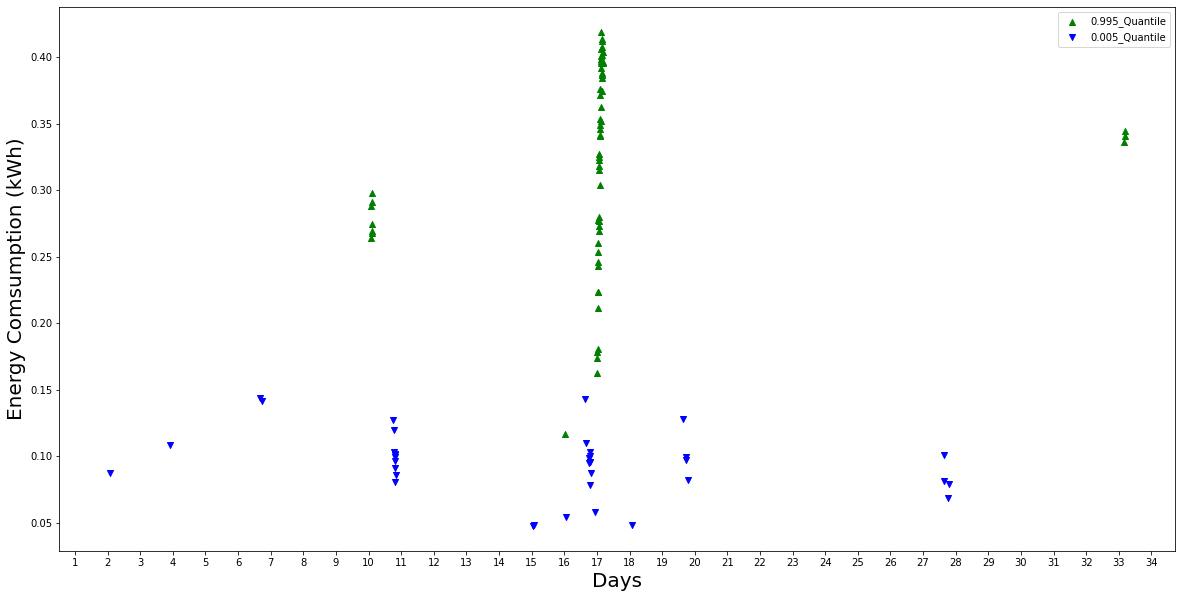

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
#plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_weekday_interval_vs_zscore.png')

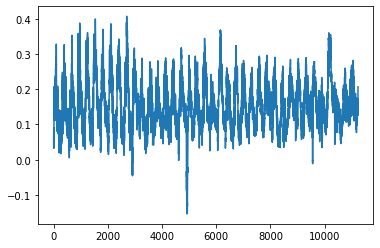

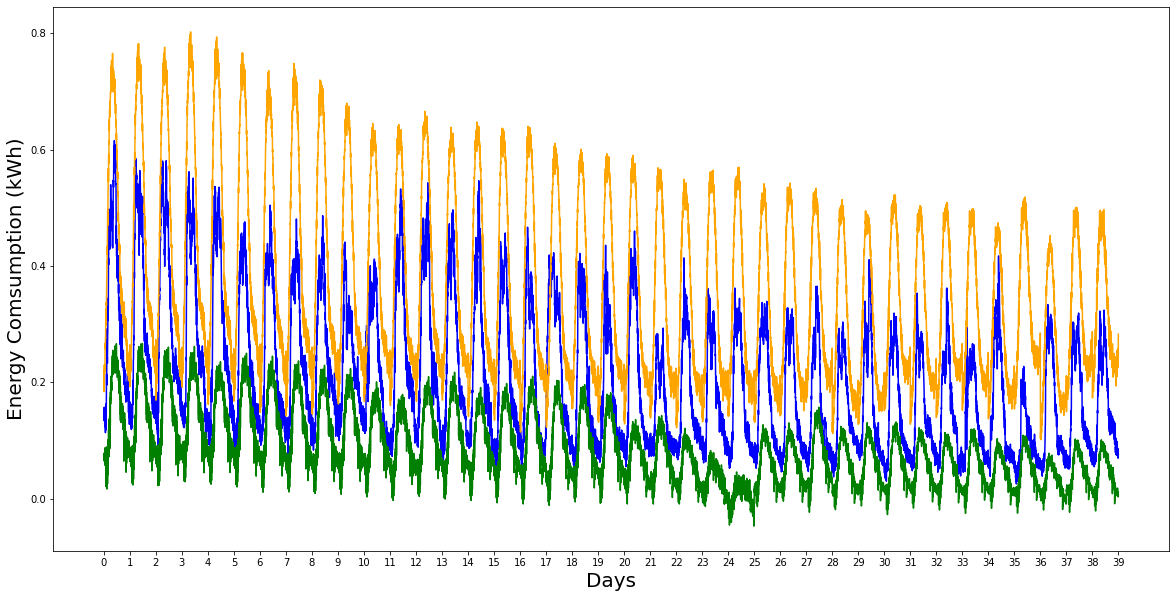

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'blue')
plt.plot(forecasts_u, color = 'orange')
plt.plot(forecasts_l, color = 'green')

In [0]:
class weekend_args:
  def __init__(self):
    self.val_start = 12*24*60
    self.test_start = 12*24*80
    self.train_seq_len = 12*24*4
    self.val_seq_len = 12*24
    
    self.seasonality = 12*24
    self.batch_size = 512
    self.num_epochs = 100
    self.hidden_dim = 100
    self.theta_1 = 288*7
    self.theta_2 = 288*7
    self.nb_blocks_per_stack = 5
    
    self.upper_quantile = args.upper_quantile
    self.lower_quantile = args.lower_quantile

    self.save_folder = 'weekend_anomalies_upper_{}_lower_{}'.format(int(100*self.upper_quantile), int(100*self.lower_quantile))

In [0]:
args = weekend_args()

In [0]:
args.save_folder

'weekend_anomalies_upper_99_lower_1'

In [0]:
os.makedirs('Anomaly_Detection/' + args.save_folder, exist_ok=True)

In [0]:
train_arr = weekend_power_series[: args.val_start]
val_arr = weekend_power_series[args.val_start: args.test_start]
test_arr = weekend_power_series[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data[i - train_seq_len: i].T.tolist())
        y.append(data[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [0]:
X_train, y_train = make_windows(train_arr)
X_val, y_val = make_windows(val_arr)
X_test, y_test = make_windows(test_arr)

100%|██████████| 4321/4321 [00:00<00:00, 16355.18it/s]


In [0]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [0]:
sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-8, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4)
loss_funk = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

In [0]:
def pinball_loss(y_true, y_pred, tau):
    err = y_true - y_pred
    return K.mean(K.maximum(tau*err, (tau-1)*err), axis = -1)

In [0]:
loss_u = lambda y_true, y_pred : pinball_loss(y_true, y_pred, args.upper_quantile)
loss_l = lambda y_true, y_pred : pinball_loss(y_true, y_pred, args.lower_quantile)

In [0]:
model_u = NBeatsNet(backcast_length = args.train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
model_u.compile_model(loss=loss_u, learning_rate = 1e-3)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 1152, 1)      0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1152)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 100)          115300      lambda_3[0][0]                   
                                                                 subtract_21[0][0]                
                                                                 subtract_22[0][0]                
                                                                 subtract_23[0][0]          

In [0]:
history_u = model_u.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Train on 15841 samples, validate on 4321 samples
Epoch 1/100


InvalidArgumentError: ignored

In [0]:
best_epoch = np.argmin(np.array(history_u.history['val_loss']))+1
model_u.save_weights('Anomaly_Detection/' + args.save_folder + '/model_upper_{:02d}.h5'.format(best_epoch))
model_u.load_weights('Anomaly_Detection/' + args.save_folder + '/model_upper_{:02d}.h5'.format(best_epoch))
best_epoch

In [0]:
y_pred_u = model_u.predict(X_test)

In [0]:
model_l = NBeatsNet(backcast_length = args.train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
model_l.compile_model(loss=loss_l, learning_rate = 1e-3)

In [0]:
history_l = model_l.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

In [0]:
best_epoch = np.argmin(np.array(history_l.history['val_loss']))+1
model_l.save_weights('Anomaly_Detection/' + args.save_folder + '/model_lower_{:02d}.h5'.format(best_epoch))
model_l.load_weights('Anomaly_Detection/' + args.save_folder + '/model_lower_{:02d}.h5'.format(best_epoch))
best_epoch

In [0]:
y_pred_l = model_l.predict(X_test)

In [0]:
plt.plot(y_test[0], color = 'blue')
plt.plot(y_pred_u[0], color = 'red')
plt.plot(y_pred_l[0], color = 'red')
plt.legend(['Actual_Value', '_Quantile'.format(args.upper_quantile), '_Quantile'.format(args.lower_quantile)])

In [0]:
forecasts_l = []
forecasts_u = []
actuals = []
for i in tqdm(range(y_pred_u.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts_u += y_pred_u[12*24*i].reshape(-1).tolist()
  forecasts_l += y_pred_l[12*24*i].reshape(-1).tolist()
  actuals += y_test[12*24*i].reshape(-1).tolist()

In [0]:
u = np.array([f_u - a for f_u, a in zip(forecasts_u, actuals)])
u_t = np.where(u < 0, actuals, None)
u_picp = np.where(u < 0, 0, 1)

In [0]:
l = np.array([a - f_l for a, f_l in zip(actuals, forecasts_l)])
l_t = np.where(l < 0, actuals, None)
l_picp = np.where(l < 0, 0, 1)

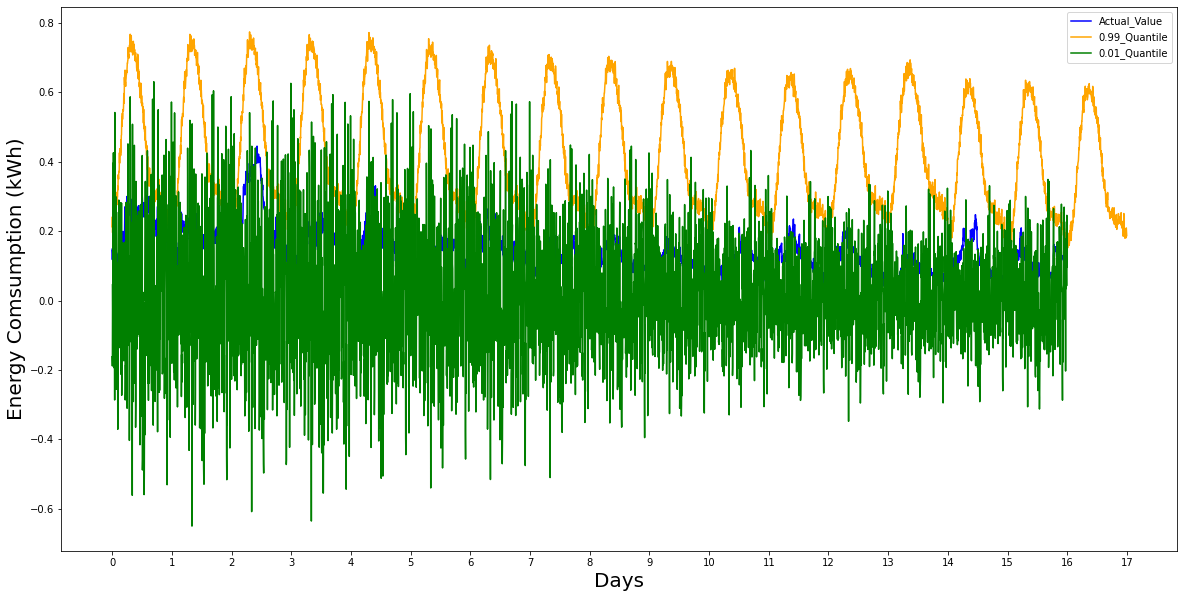

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'blue')
plt.plot(forecasts_u, color = 'orange')
plt.plot(forecasts_l, color = 'green')
plt.legend(['Actual_Value', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/quantiles_weekday_{}_{}.png'.format(args.upper_quantile, args.lower_quantile))

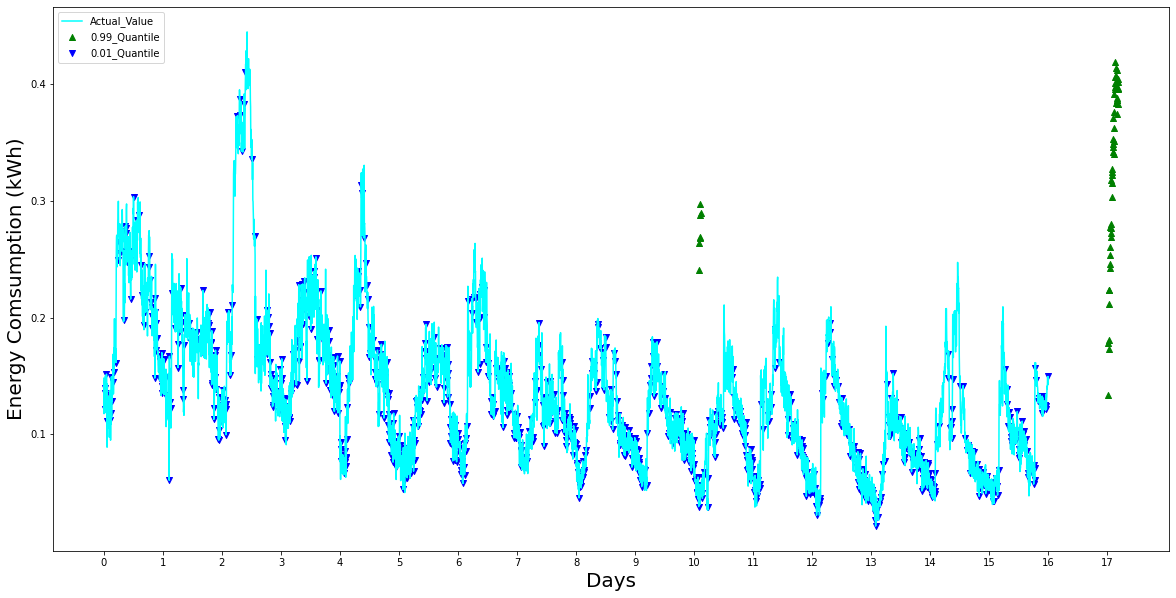

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'cyan')
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['Actual_Value', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_actuals_weekday_{}_{}.png'.format(args.upper_quantile, args.lower_quantile))

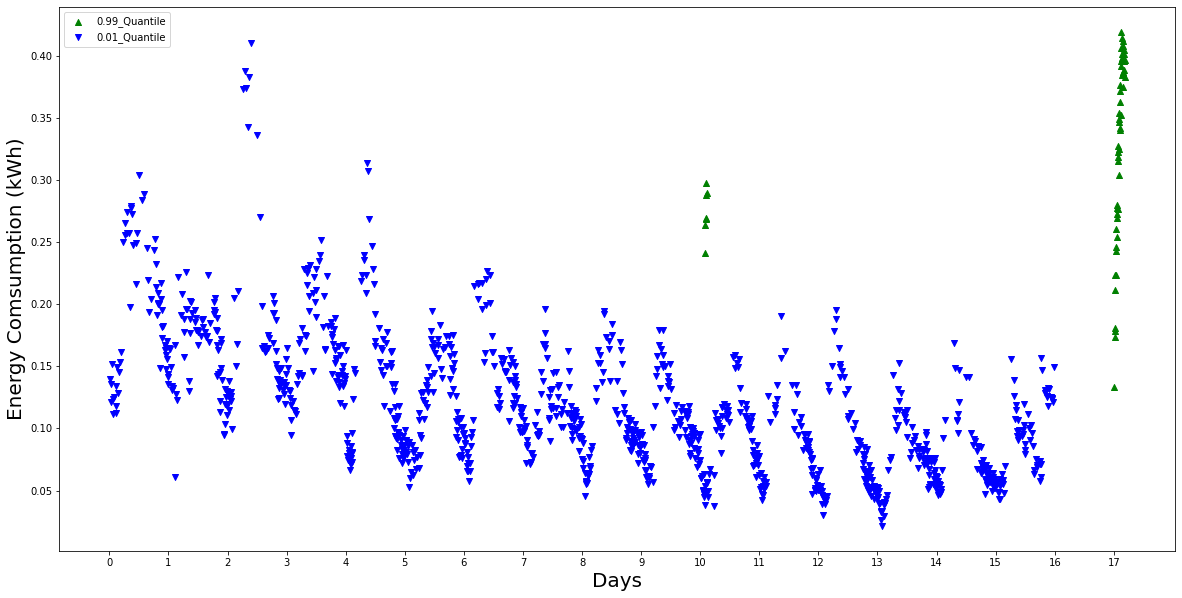

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_weekday_{}_{}.png'.format(args.upper_quantile, args.lower_quantile))

In [0]:
if not os.path.exists('Anomaly_Detection/PI_eval_metrics.csv'):
  results = po.DataFrame(columns = ['model', 'upper_quantile', 'lower_quantile', 'PICP', 'PINAW'])  
else: 
  results = po.read_csv('Anomaly_Detection/PI_eval_metrics.csv')

In [0]:
PICP = (np.sum(l_picp) + np.sum(u_picp))/(len(l_picp) + len(u_picp))
PICP

0.9222222222222223

In [0]:
E = np.array(actuals).max() - np.array(actuals).min()
N = len(actuals)

In [0]:
u_l = np.array([f_u - f_l for f_u, f_l in zip(forecasts_u, forecasts_l)])

In [0]:
PINAW = np.sum(u_l)/(N*E)
PINAW

0.9546730320197214

In [0]:
mu = 0.965
eta = 2

In [0]:
gamma = 0 if PICP >= mu else 1

In [0]:
CWC = PINAW*(1 + gamma*np.exp(eta*(mu - PICP)))
CWC

1.9946194426463606

In [0]:
errors = {'model': 'NBEATS_weekend',
          'upper_quantile': args.upper_quantile,
          'lower_quantile': args.lower_quantile,
          'PICP': PICP,
          'PINAW': PINAW,
          'CWC': CWC      
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [0]:
results

,model,upper_quantile,lower_quantile,PICP,PINAW,CWC
0,NBEATS_weekday,0.96,0.03,0.996928,0.565448,4.769320
1,NBEATS_weekend,0.96,0.03,0.985185,0.415431,0.415431
2,NBEATS_weekday,0.98,0.03,0.969373,0.331278,2.933738
3,NBEATS_weekend,0.98,0.03,0.963889,0.422425,0.845790
4,NBEATS_weekday,0.96,0.01,0.991186,0.418753,3.567975
5,NBEATS_weekend,0.96,0.01,0.993981,0.413482,0.413482
6,NBEATS_weekday,0.97,0.04,0.933271,0.283406,2.676486
7,NBEATS_weekday,0.97,0.04,0.915198,0.277274,2.704754
8,NBEATS_weekend,0.97,0.04,0.962500,0.366350,0.734535
9,NBEATS_weekday,0.98,0.02,0.980992,0.348774,3.025742


In [0]:
results.to_csv('Anomaly_Detection/PI_eval_metrics.csv', index=False)

In [0]:
z_scores = stats.zscore(np.array(actuals))

In [0]:
z_u = np.where(z_scores > 3, actuals, None)
z_l = np.where(z_scores < -3, actuals, None)

In [0]:
z_u_picp = np.where(z_scores > 3, 0, 1)
z_l_picp = np.where(z_scores < -3, 0, 1)

In [0]:
z_PICP = (np.sum(z_u_picp) + np.sum(z_l_picp))/(len(z_u_picp) + len(z_l_picp))
z_PICP

0.9905598958333334

In [0]:
'''
errors = {'model': 'z_score',
          'upper_quantile': args.upper_quantile,
          'lower_quantile': args.lower_quantile,
          'PICP': PICP,     
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)
results
results.to_csv('Anomaly_Detection/picp_pinaw.csv', index=False)
'''

"\nerrors = {'model': 'z_score',\n          'upper_quantile': args.upper_quantile,\n          'lower_quantile': args.lower_quantile,\n          'PICP': PICP,     \n          }\nerrors = po.Series(errors)\nresults = results.append(errors, ignore_index=True)\nresults\nresults.to_csv('Anomaly_Detection/picp_pinaw.csv', index=False)\n"

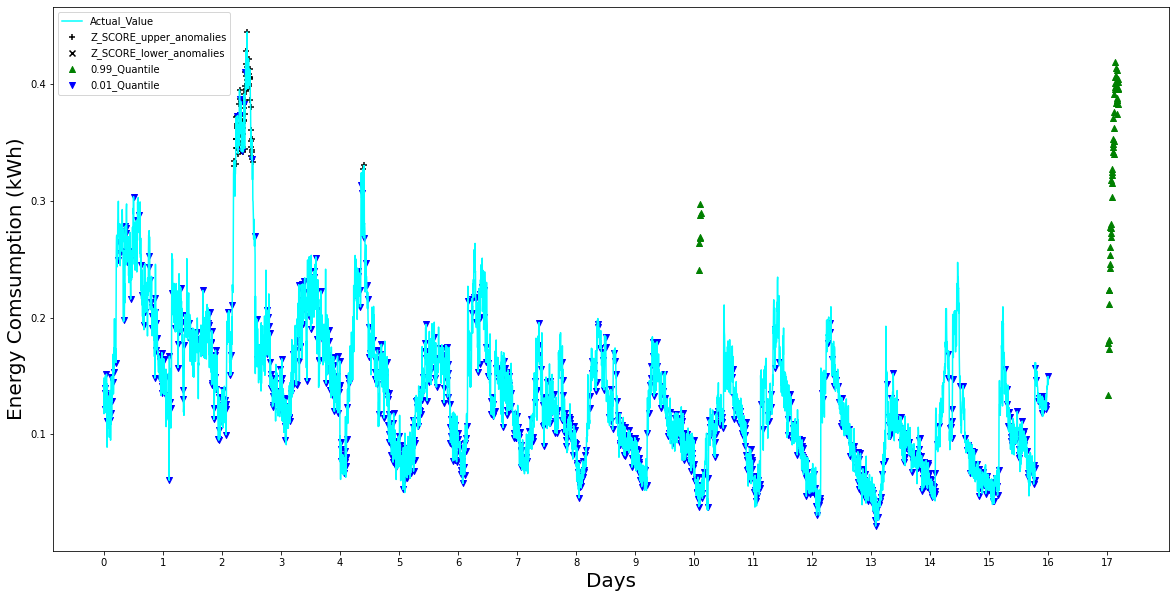

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'cyan')
plt.scatter(range(len(z_u)), z_u, color = 'black', marker = '+')
plt.scatter(range(len(z_l)), z_l, color = 'black', marker = 'x')
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['Actual_Value', 'Z_SCORE_upper_anomalies', 'Z_SCORE_lower_anomalies', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_actuals_weekday_interval_vs_zscore.png')

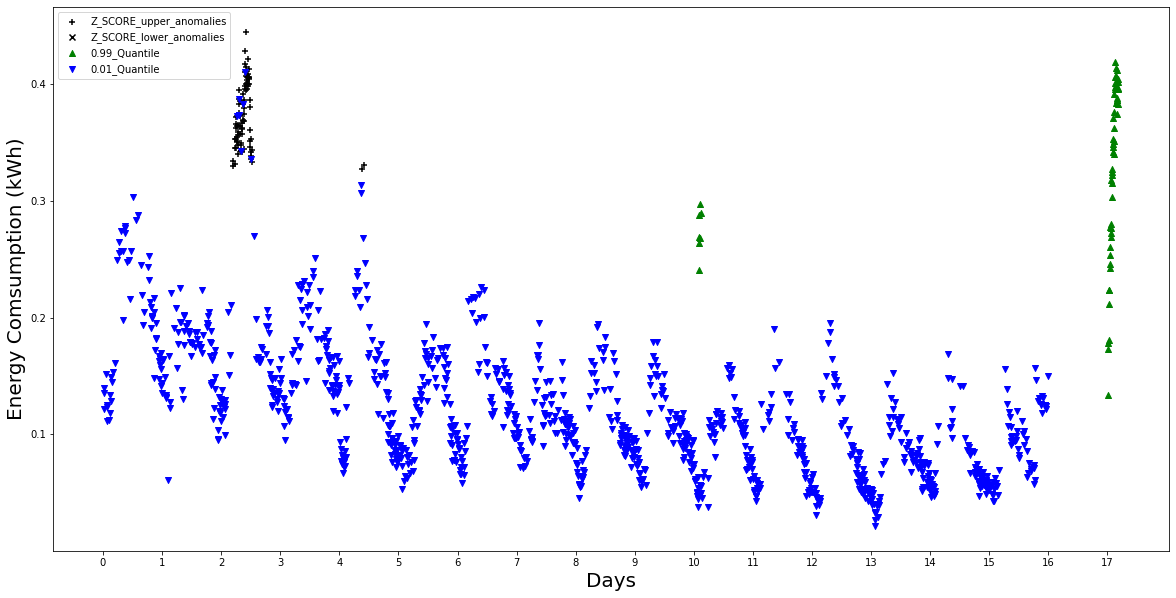

In [0]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.scatter(range(len(z_u)), z_u, color = 'black', marker = '+')
plt.scatter(range(len(z_l)), z_l, color = 'black', marker = 'x')
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['Z_SCORE_upper_anomalies', 'Z_SCORE_lower_anomalies', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_weekday_interval_vs_zscore.png')

In [0]:
with open('Anomaly_Detection/' + args.save_folder + '/forecasts_u.pkl', 'wb') as f:
  pickle.dump(forecasts_u, f)

In [0]:
with open('Anomaly_Detection/' + args.save_folder + '/forecasts_l.pkl', 'wb') as f:
  pickle.dump(forecasts_l, f)

In [0]:
with open('Anomaly_Detection/' + args.save_folder + '/actuals.pkl', 'wb') as f:
  pickle.dump(actuals, f)

In [0]:
results

,model,upper_quantile,lower_quantile,PICP,PINAW,CWC
0,NBEATS_weekday,0.96,0.03,0.996928,0.565448,4.769320
1,NBEATS_weekend,0.96,0.03,0.985185,0.415431,0.415431
2,NBEATS_weekday,0.98,0.03,0.969373,0.331278,2.933738
3,NBEATS_weekend,0.98,0.03,0.963889,0.422425,0.845790
4,NBEATS_weekday,0.96,0.01,0.991186,0.418753,3.567975
5,NBEATS_weekend,0.96,0.01,0.993981,0.413482,0.413482
6,NBEATS_weekday,0.97,0.04,0.933271,0.283406,2.676486
7,NBEATS_weekday,0.97,0.04,0.915198,0.277274,2.704754
8,NBEATS_weekend,0.97,0.04,0.962500,0.366350,0.734535
9,NBEATS_weekday,0.98,0.02,0.980992,0.348774,3.025742
